In [1]:
import torch
import torch.nn as nn        # Pytorch neural network package
import torch.optim as optim  # Pytorch optimization package
import torch.nn.functional as F
import numpy
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda")

In [6]:
features = 16
# define a simple linear VAE #until now normal VAE without Beta
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder 84*84 = 7’056
        self.enc0 = nn.Linear(in_features=84*84, out_features=1024)
        self.enc1 = nn.Linear(in_features=1024, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)
 
        # decoder 
        self.dec0 = nn.Linear(in_features=features, out_features=512)
        self.dec1 = nn.Linear(in_features=512, out_features=1024)
        self.dec2 = nn.Linear(in_features=1024, out_features=84*84)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    
    def encode(self, x):
        x = F.relu(self.enc0(x))
        x = F.relu(self.enc1(x))
        x = self.enc2(x)
        return x

In [7]:
#train_data = numpy.load('train_data100kFEB23.npy')
#val_data = numpy.load('val_data20kFEB23.npy')

In [8]:
#print(train_data.shape)

In [9]:
BVAE = LinearVAE()
BVAE.load_state_dict(torch.load('C:/Users/erics/Documents/Programme/Bachelorarbeit/models/BTCVAE_Pong/linearB500_TC0_Lat16lr0.0001VAEMAR23'))
BVAE.to(device)

LinearVAE(
  (enc0): Linear(in_features=7056, out_features=1024, bias=True)
  (enc1): Linear(in_features=1024, out_features=512, bias=True)
  (enc2): Linear(in_features=512, out_features=32, bias=True)
  (dec0): Linear(in_features=16, out_features=512, bias=True)
  (dec1): Linear(in_features=512, out_features=1024, bias=True)
  (dec2): Linear(in_features=1024, out_features=7056, bias=True)
)

In [10]:
randomInput = torch.rand(256, 7056, device=device) #7056 = 84* 84
print(randomInput)


tensor([[0.0620, 0.0652, 0.7281,  ..., 0.6774, 0.9089, 0.0212],
        [0.3111, 0.4260, 0.7615,  ..., 0.6756, 0.7612, 0.9788],
        [0.8249, 0.3151, 0.9943,  ..., 0.1156, 0.1904, 0.0051],
        ...,
        [0.8795, 0.6317, 0.3246,  ..., 0.1916, 0.7111, 0.0950],
        [0.6447, 0.9385, 0.4128,  ..., 0.8210, 0.0492, 0.0403],
        [0.4690, 0.5958, 0.5648,  ..., 0.0303, 0.4305, 0.9896]],
       device='cuda:0')


In [11]:
enco = BVAE.encode(randomInput)
print(enco)

tensor([[-1.7102e+00,  6.0599e-01, -1.6721e+00,  ..., -1.8208e+01,
          1.3780e+00, -1.4332e+01],
        [-1.6018e+00, -1.7355e-02, -2.1110e+00,  ..., -1.8300e+01,
          1.4892e+00, -1.4890e+01],
        [-1.6993e+00,  6.9022e-01, -1.3260e+00,  ..., -1.8575e+01,
          1.4178e+00, -1.4380e+01],
        ...,
        [-1.5484e+00,  9.4183e-02, -1.9615e+00,  ..., -1.8651e+01,
          1.4097e+00, -1.5004e+01],
        [-1.5856e+00,  4.8102e-02, -1.9531e+00,  ..., -1.8503e+01,
          1.4000e+00, -1.4434e+01],
        [-1.6389e+00, -2.9959e-03, -1.6801e+00,  ..., -1.9010e+01,
          1.4180e+00, -1.4854e+01]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [12]:
def KLdiv(mu, logvar):
    print(mu.size())
    print((1 + logvar - mu.pow(2) - logvar.exp()).size())
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print(KLD.size())
    return KLD

def compute_gaussian_kl(z_mean, z_logvar):
    return np.mean(0.5 * (np.square(z_mean) + np.exp(z_logvar) - z_logvar - 1), axis=0)

In [13]:
x = enco.view(-1, 2, features)
# get `mu` and `log_var`
mu = x[:, 0, :] # the first feature values as mean
log_var = x[:, 1, :]

KLenco = compute_gaussian_kl(mu.detach().cpu().numpy(), log_var.detach().cpu().numpy())
#print(KLenco.size())
print(KLenco.ndim)

#TODO: Wie macht man dimensionwise KL-divergence??

1


In [14]:
#enco = enco.detach().cpu().numpy()
#KLencoNP = KLenco.detach().cpu().numpy()

In [15]:
print(KLenco.shape)

(16,)


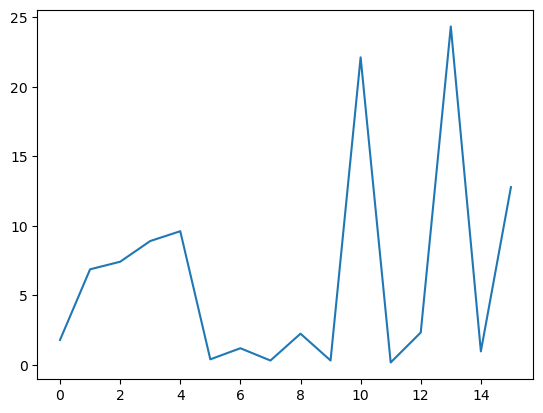

In [16]:
plt.plot(KLenco)
plt.show()

In [17]:
#KLencoMean = numpy.mean(KLenco, axis=0) # in kl_gaussian wird schon mean genommen

In [18]:
#plt.plot(KLencoMean)
#plt.show()

In [19]:
numZero = (numpy.histogram(KLenco, bins=(-0.5, 0.01))[0])/2 #/2 da logvar & mean
print(numZero)

[0.]


In [21]:
Nonzero = features-numZero
print(Nonzero)

[16.]
